# LoC Data Package Tutorial: 1000 Dot Gov PDF Dataset

This notebook will demonstrate basic usage of using Python for interacting with [data packages from the Library of Congress](https://data.labs.loc.gov/packages/) via the [Dot Gov Data Package](https://data.labs.loc.gov/dot-gov/) which is derived indexes of the web archives of .gov websites created by the Library's Web Archives Team. We will:

1. [Output a summary of the contents of this data package](#Output-data-package-summary)
2. [Read and query metadata from a data package](#Query-the-metadata-in-a-data-package)
3. [Parse and display a PDF](#Parse-and-display-a-PDF)

## Prerequisites

In order to run this notebook, please follow the instructions listed in [this directory's README](https://github.com/LibraryOfCongress/data-exploration/blob/master/Data%20Packages/README.md).

## Output data package summary

First we will output a summary of the data package contents

In [2]:
import pandas as pd                     # for reading, manipulating, and displaying data
import requests

from helpers import get_file_stats

DATA_URL = 'https://data.labs.loc.gov/dot-gov/pdf_data/' # Base URL of this data package's PDF data

# Download the file manifest
file_manifest_url = f'{DATA_URL}manifest.json'
response = requests.get(file_manifest_url, timeout=60)
response_json = response.json()
files = [dict(zip(response_json["cols"], row)) for row in response_json["rows"]] # zip columns and rows

# Convert to Pandas DataFrame and show stats table
stats = get_file_stats(files)
pd.DataFrame(stats)

,FileType,Count,Size
0,.pdf,"1,000",794MB
1,.csv,1,529KB
2,.txt,1,10KB


## Query the metadata in a data package

Next we will download and open the .gov PDF metadata file

In [3]:
import io

# Read contents as a csv file
metadata_url = f'{DATA_URL}metadata.csv'
response = requests.get(metadata_url, timeout=60)
metadata_string = response.text
df = pd.read_csv(io.StringIO(metadata_string), dtype=str, keep_default_na=False)
print(f'Loaded metadata file with {df.shape[0]:,} entries.')

Loaded metadata file with 1,000 entries.


And print the available properties

In [4]:
print(', '.join(df.columns.to_list()))

urlkey, timestamp, original, mimetype, statuscode, digest, pdf_version, creator_tool, producer, date_created, pages, page_width, page_height, surface_area, file_size, sha256, sha512


And print a summary of the PDF versions

In [5]:
df['pdf_version'].explode().value_counts().iloc[:10].to_frame()

,pdf_version
1.4,281
1.5,253
1.3,172
1.2,117
1.6,116
1.1,31
-,13
1.7,12
1,5


And then print a histogram of the files' page counts

Page count range: [1, 1178]


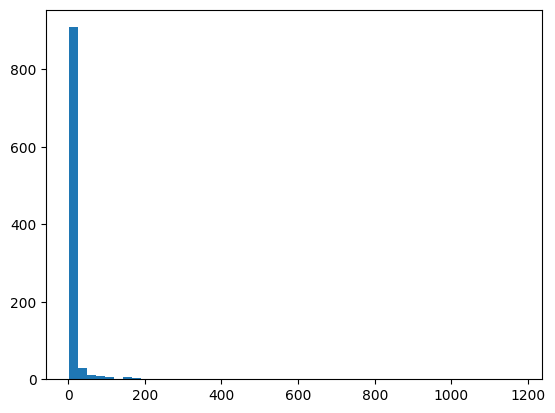

In [13]:
import matplotlib.pyplot as plt
import numpy as np

page_counts = [int(p) for p in df['pages'].to_list() if str(p).isdigit()]
print(f"Page count range: [{min(page_counts)}, {max(page_counts)}]")
fig, ax = plt.subplots()
ax.hist(page_counts, bins=50)
# plt.xticks(np.arange(min(page_counts), max(page_counts) + 1, 10))
plt.show()

Now let's filter by PDFs from congress.gov

In [14]:
df_subset = df[df['original'].str.contains("congress.gov")]
print(f'Found {df_subset.shape[0]:,} items with "congress.gov" in the original URL')

Found 4 items with "congress.gov" in the original URL


## Parse and display a PDF

Let's select the first PDF from the congress.gov subset

In [17]:
item = df_subset.iloc[0]
item_url = f"{DATA_URL}data/{item['digest']}.pdf"
print(f"Ready to download PDF: {item_url}\nThat was originally from: {item['original']}")

Ready to download PDF: https://data.labs.loc.gov/dot-gov/pdf_data/data/H7U4KMXPQKUBDKIPQQRC6ETJZEZR3OCZ.pdf
That was originally from: https://congress.gov/crec/2016/04/05/CREC-2016-04-05-pt1-PgS1675-4.pdf


Download and load the PDF file

In [18]:
from pypdf import PdfReader

response = requests.get(item_url, timeout=60)
filestream = io.BytesIO(response.content)

reader = PdfReader(filestream)
number_of_pages = len(reader.pages)
print(f"Loaded PDF and found {number_of_pages} pages")

Loaded PDF and found 2 pages


Load preview the text inside the PDF

In [22]:
text = ''
for page in reader.pages:
    text += page.extract_text()
    text += '\n'
print(f'Loaded text with length {len(text):,}. Preview:\n')
print(f'{text[:300]}...')

Loaded text with length 15,814. Preview:

CONGRESSIONAL RECORD — SENATE S1675 April 5, 2016 
S. RES. 406 
At the request of Ms. M IKULSKI , the 
name of the Senator from Wyoming (Mr. E
NZI) was added as a cosponsor of 
S. Res. 406, a resolution recognizing the Girl Scouts of the United States of America on the 100th Anniversary of the Girl ...


Clean up text

In [23]:
import re

whitespace_pattern = re.compile(r"\s+")
nonword_pattern = re.compile(r" [\S]*[\\\^<>]+[\S]* ")
tinyword_pattern = re.compile(r" [\S][\S]?[\S]? ")
text = text.replace('\\n', '')
text = whitespace_pattern.sub(" ", text).strip()
text = nonword_pattern.sub(" ", text)
text = tinyword_pattern.sub(" ", text)
text = whitespace_pattern.sub(" ", text).strip()

And finalize visualize the text using a word cloud

(-0.5, 399.5, 199.5, -0.5)

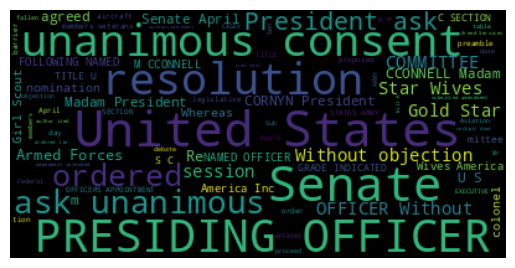

In [24]:
from wordcloud import WordCloud

# Generate a word cloud image
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")